In [1]:
from typing import Any, Callable, List, Optional, Tuple, Dict
import json, sys
import numpy as np
import pandas as pd
import os
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from utils.env_utils import keep_only_core_observations, keep_only_electrical_storage

print('Python:', sys.version.split()[0])
print('CityLearn:', citylearn.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-09-21 10:07:42.157951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-21 10:07:42.172003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758442062.186265  979497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758442062.190371  979497 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758442062.202154  979497 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
CityLearn: 2.4.1


In [2]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/rbc0'
RBC_LOG_FILE = os.path.join(LOG_DIR, "rbc_agent_logs_0.csv")
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0,
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

In [ ]:
class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str],
                    action_space: List[str],
                    rule_defs: List[Dict] = None, 
                    thresholds: Dict[str, float] = None,
                    history: List[Tuple[Dict[str, float], str, float]] = None,
                    obs_index_map: Optional[Dict[str, int]] = None):
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0
        done = False
        while not done and (max_steps is None or steps < max_steps):
            obs_all = env.observations
            obs_vec  = obs_all[0]
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}
            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)
            action = self.act(obs_dict)
            frac_map = { 
                '100%_charge': 1.0, 
                '50%_charge': 0.5, 
                'idle': 0.0, 
                '50%_discharge': -0.5, 
                '100%_discharge': -1.0 } 
            frac = frac_map[action]
            N = env.action_space[0].shape[0]
            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)
            step_reward = float(reward_list[0])
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))
            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)
            steps += 1
        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            print(f"Episode {_ + 1}/{episodes}")
            episode_reward, episode_history = self.evaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return self.rewards, self.histories

In [5]:
# ca 10min
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)  # Load schema for the dataset
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN # Set reward function

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # (fixes "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

five_level_actions = ['100%_charge', '50%_charge', 'idle', '50%_discharge', '100%_discharge']
five_level_rules=[
    # 100% charge: soc <= 0.20    
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_empty'}], 
        'action':'idle'},
    # 50% charge: 0.20 < soc <= 0.30    
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_empty'}], 
        'action':'idle'}
]
thresholds={
    'soc_empty': 0.2, 
    'soc_low': 0.3,
    'soc_mid': 0.55, 
    'soc_high': 0.8, 
    'price': 0.04, 
}
env = CityLearnEnv(schema, central_agent=True)
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=five_level_actions,
                 rule_defs=five_level_rules,
                 thresholds=thresholds,
                 history=[])


"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-09-21_10-08-16'


'\n0: day_type\n1: hour\n2: outdoor_dry_bulb_temperature\n3: outdoor_dry_bulb_temperature_predicted_1\n4: outdoor_dry_bulb_temperature_predicted_2\n5: outdoor_dry_bulb_temperature_predicted_3\n6: diffuse_solar_irradiance\n7: diffuse_solar_irradiance_predicted_1\n8: diffuse_solar_irradiance_predicted_2\n9: diffuse_solar_irradiance_predicted_3\n10: direct_solar_irradiance\n11: direct_solar_irradiance_predicted_1\n12: direct_solar_irradiance_predicted_2\n13: direct_solar_irradiance_predicted_3\n14: carbon_intensity\n15: indoor_dry_bulb_temperature\n16: non_shiftable_load\n17: solar_generation\n18: dwh_storage_soc\n19: electrical_storage_soc\n20: net_electricity_consumption\n21: electricity_pricing\n22: electricity_pricing_predicted_1\n23: electricity_pricing_predicted_2\n24: electricity_pricing_predicted_3\n25: cooling demand\n26: dwh demand\n27: occupant count\n28: power_outage\n29: indoor_dry_bulb_temperature_cooling_set_point\n'

In [ ]:
# evaluate 1 episode
r, hist = agent.evaluate(env)  # max steps while debugging

#rewards, histories = agent.multiple_evaluation(env, episodes=30)  

logs = [{'timestep': t, **obs, 'action': action, 'reward': reward} for t, (obs, action, reward) in enumerate(hist)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])

In [7]:
# safe logs
df.to_csv(RBC_LOG_FILE, index=False)

# Debug
print(f"Episode has {len(hist)} timesteps.")
print('Reward function:', type(env.reward_function).__name__)
print(env.schema['buildings'][env.buildings[0].name]['pricing'])

NameError: name 'df' is not defined

In [ ]:
try:
    df = pd.read_csv(RBC_LOG_FILE)
except FileNotFoundError:
    print(f"Log file '{RBC_LOG_FILE}' not found.")

In [ ]:
from citylearn.citylearn import CityLearnEnv

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def replay_hist_and_capture(env, hist, building_idx=0, broadcast=False):
    """Replay the recorded actions and capture true arrays per step."""
    base = unwrap_to_citylearn(env)
    base.reset()
    b = base.buildings[building_idx]
    N = base.action_space[0].shape[0]

    NAME_TO_FRAC = {'100%_discharge':-1.0,'50%_discharge':-0.5,'idle':0.0,'50%_charge':0.5,'100%_charge':1.0}

    net_true, nsl_true, price_true, solar_true = [], [], [], []
    for obs_dict, action_name, _ in hist:
        frac = float(np.clip(NAME_TO_FRAC[action_name], -1.0, 1.0))
        if broadcast:
            act = [float(frac)]*N
        else:
            act = [0.0]*N
            act[0] = float(frac)

        # step env
        base.step([act])

        # read current time index and prefer non-zero current idx
        ts_now = b.time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(b.net_electricity_consumption[ts_now])
        net_idx = float(b.net_electricity_consumption[ts_idx])
        net_true.append(net_idx if net_now == 0.0 else net_now)

        nsl_now = float(b.non_shiftable_load[ts_now])
        nsl_idx = float(b.non_shiftable_load[ts_idx])
        nsl_true.append(nsl_idx if nsl_now == 0.0 else nsl_now)

        # optional context
        price_true.append(float(b.pricing.electricity_pricing[ts_now]) if b.pricing is not None else np.nan)
        solar_true.append(float(b.solar_generation[ts_now]))

    return np.array(net_true), np.array(nsl_true), np.array(price_true), np.array(solar_true)


ep_logs = []
for t, (obs, act, rew) in enumerate(hist): 
    row = {'t': t, 'action': act, 'reward': rew}
    for k in ('soc','price','net_load','solar_generation'):
        if k in obs:
            row[k] = obs[k]
    ep_logs.append(row)
df = pd.DataFrame(ep_logs)

net_true, nsl_true, price_true, solar_true = replay_hist_and_capture(env, hist, building_idx=0, broadcast=False)
df['net_load'] = net_true
df['non_shiftable_load'] = nsl_true
print("Sanity check net_load:", float(np.nanmin(df['net_load'])), "to", float(np.nanmax(df['net_load'])))

Sanity check net_load: -0.9904451370239258 to 9.699407577514648


#### Plotting

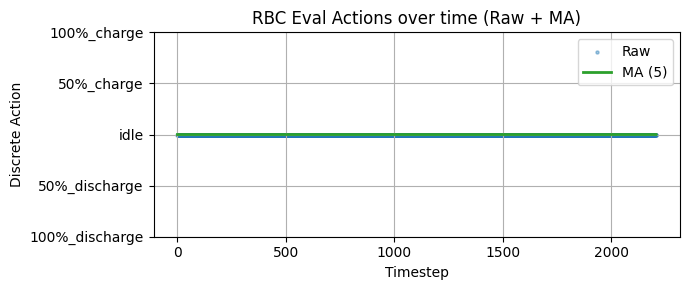

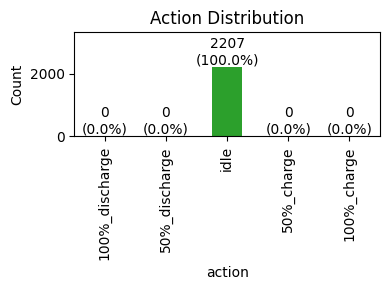

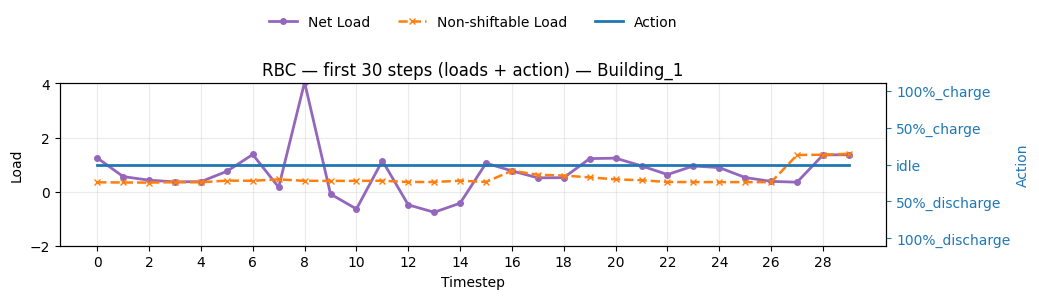

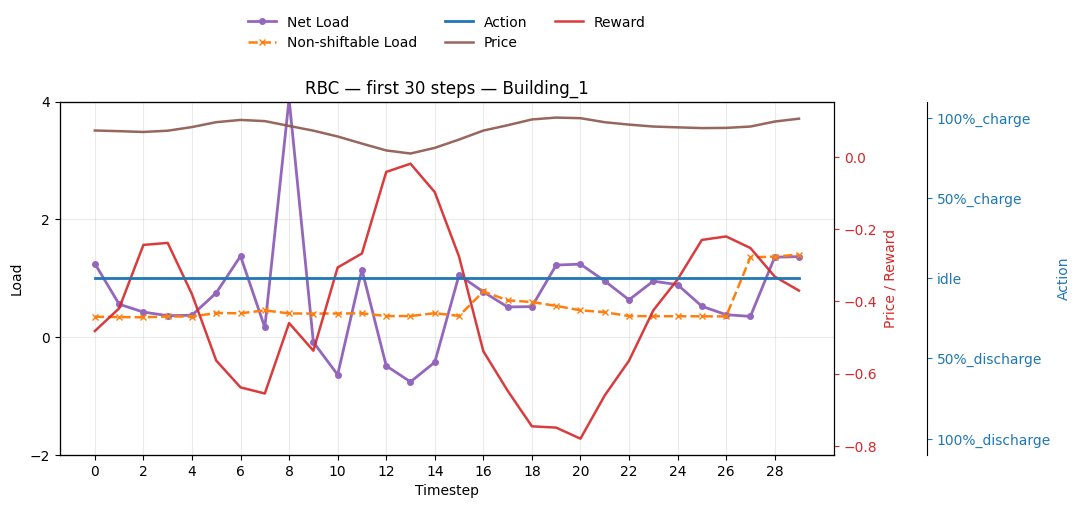

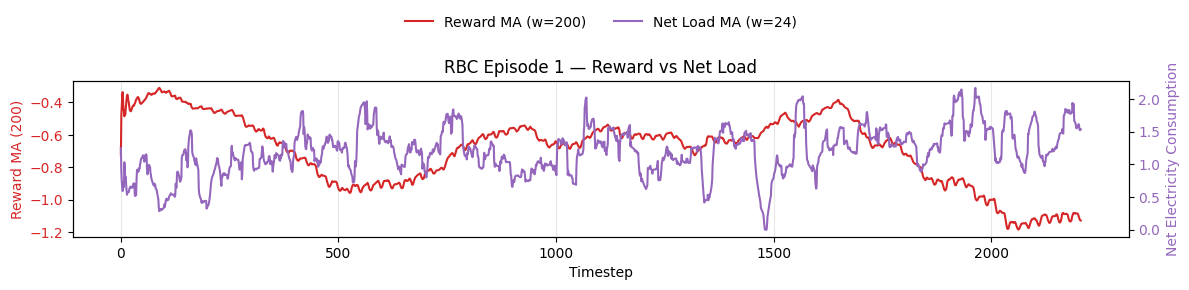

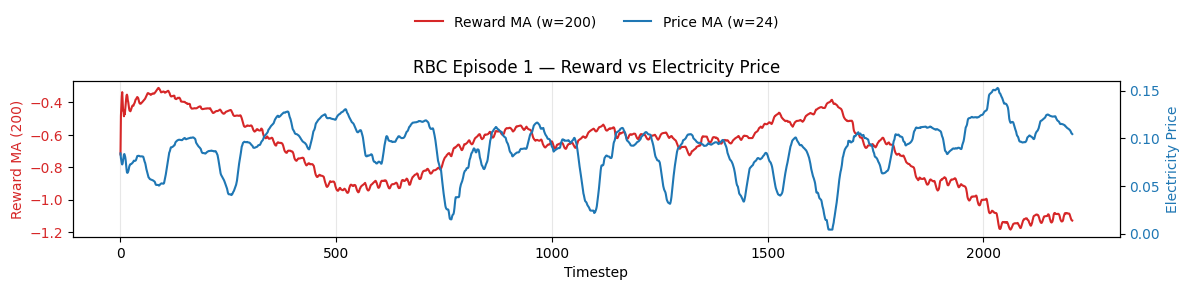

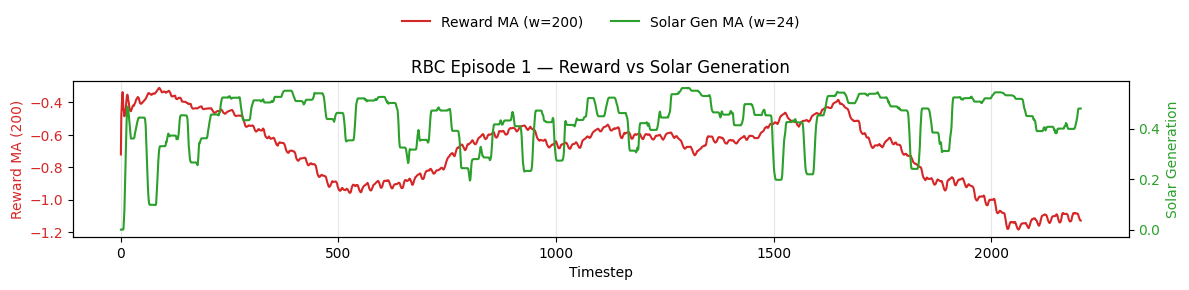

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


# ----- Plot 1: RBC Eval Actions over time (Raw + MA) -----
window = 5
df['action_num'] = df['action'].map(NAME_TO_FRAC)
df['action_ma'] = df['action_num'].rolling(window, min_periods=1).mean()
plt.figure(figsize=(7,3))
plt.scatter(df['t'], df['action_num'], s=5, alpha=0.4, label='Raw')
plt.plot(
    df['t'], 
    df['action_ma'], 
    color='C2', lw=2,
    label=f"MA ({window})"
)
plt.xlabel('Timestep'); 
#df = timesteps_to_days(df)
plt.title(f"RBC Eval Actions over time (Raw + MA)")
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], ACTION_LABELS)
plt.ylabel('Discrete Action'); plt.legend(loc="upper right"); plt.grid(True); plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution -----
plt.figure(figsize=(4,3))
counts = df['action'].value_counts().reindex(ACTION_LABELS).fillna(0)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def plot_first_30_steps_actions_vs_loads_rbc(agent, env, building_name="Building_1"):
    """Single panel: net & non-shiftable load (left) + discrete action (right), first 30 steps."""
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # Reset and collect first 30 steps
    base.reset()
    t_list, net_list, nsl_list, act_frac_list = [], [], [], []
    for t in range(30):
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
        }

        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        _, _, terminated, truncated, _ = base.step([flat])

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)
        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)

        if bool(terminated) or bool(truncated):
            break

    # Arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)

    # Plot: loads (left) + action (right)
    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    ax1.plot(t, nsl, color='C1', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.set_xticks(t[::2])
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, which='both', axis='both', alpha=0.25)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', lw=2.0, label='Action')
    ax2.set_ylabel('Action', color='C0')
    ax2.tick_params(axis='y', colors='C0')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax2.set_yticklabels(ACTION_LABELS)
    add_top_legend(ax1, ax2)
    plt.title(f'RBC — first 30 steps (loads + action) — {building_name}')
    plt.tight_layout()
    plt.show()

def plot_first_30_steps_actions_vs_obs_rbc(agent, env, building_name="Building_1",
                                                          normalize_price_reward: bool = False,
                                                          smooth_window: int = 1):
    base = unwrap_to_citylearn(env)
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)

    # reset
    base.reset()
    t_list, net_list, nsl_list, act_frac_list, price_list, reward_list = [], [], [], [], [], []

    for t in range(30):
        # Build observation dict for the agent (like in evaluate())
        obs_vec = base.observations[b_idx]
        obs_names_b = base.observation_names[b_idx]
        idx = {n: i for i, n in enumerate(obs_names_b)}
        b0 = base.buildings[b_idx]
        ts = b0.time_step
        soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
        obs_dict = {
            'soc': float(soc),
            'price': float(obs_vec[idx['electricity_pricing']]) if 'electricity_pricing' in idx else np.nan,
            'solar_generation': float(obs_vec[idx['solar_generation']]) if 'solar_generation' in idx else np.nan,
        }

        # Agent action (string) -> fraction
        a_name = agent.act(obs_dict)
        a_frac = float(np.clip(NAME_TO_FRAC[a_name], -1.0, 1.0))

        # Central agent action vector (control first storage dim only)
        N = base.action_space[0].shape[0]
        flat = [0.0] * N
        flat[0] = a_frac

        # Step and capture reward
        _, rew, terminated, truncated, _ = base.step([flat])
        step_reward = float(rew[b_idx] if isinstance(rew, (list, tuple, np.ndarray)) else rew)

        # Read arrays (prefer non-zero for net load)
        ts_now = base.buildings[b_idx].time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(base.buildings[b_idx].net_electricity_consumption[ts_now])
        net_idx = float(base.buildings[b_idx].net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(base.buildings[b_idx].non_shiftable_load[ts_now])
        nsl_idx = float(base.buildings[b_idx].non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price_now = float(base.buildings[b_idx].pricing.electricity_pricing[ts_now]) if base.buildings[b_idx].pricing is not None else np.nan

        t_list.append(t)
        net_list.append(net_use)
        nsl_list.append(nsl_use)
        act_frac_list.append(a_frac)
        price_list.append(price_now)
        reward_list.append(step_reward)

        if bool(terminated) or bool(truncated):
            break

    # Prepare arrays
    t = np.arange(len(t_list))
    net = np.asarray(net_list, dtype=float)
    nsl = np.asarray(nsl_list, dtype=float)
    act = np.asarray(act_frac_list, dtype=float)
    price = np.asarray(price_list, dtype=float)
    reward = np.asarray(reward_list, dtype=float)

    # Optional smoothing for price/reward
    if smooth_window and smooth_window > 1 and len(t) > 1:
        import pandas as _pd
        price = _pd.Series(price).rolling(smooth_window, min_periods=1, center=True).mean().to_numpy()
        reward = _pd.Series(reward).rolling(smooth_window, min_periods=1, center=True).mean().to_numpy()

    # Optional normalization to overlay cleanly on one axis
    def _minmax(x):
        xmin = np.nanmin(x)
        xmax = np.nanmax(x)
        return (x - xmin) / (xmax - xmin + 1e-9) if np.isfinite(xmin) and np.isfinite(xmax) else x

    price_plot = _minmax(price) if normalize_price_reward else price
    reward_plot = _minmax(reward) if normalize_price_reward else reward
    right_label = 'Price / Reward (normalized)' if normalize_price_reward else 'Price / Reward'

    # Plot
    fig, ax1 = plt.subplots(figsize=(11, 5.2))

    # Left axis: loads
    l1 = ax1.plot(t, net, color='C4', lw=2.0, marker='o', ms=4, label='Net Load')
    l2 = ax1.plot(t, nsl, color='C1', lw=1.8, ls='--', marker='x', ms=5, label='Non-shiftable Load')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.set_xticks(t[::2])
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, which='both', axis='both', alpha=0.25)

    # Right axis (inner): price and reward
    ax2 = ax1.twinx()
    l4 = ax2.plot(t, price_plot, color='C5', lw=1.8, alpha=0.9, label='Price')
    l5 = ax2.plot(t, reward_plot, color='C3', lw=1.8, alpha=0.9, label='Reward')
    ax2.set_ylabel(right_label, color='C3')
    ax2.tick_params(axis='y', colors='C3')

    # Right axis (outer): action (discrete)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.12))
    ax3.spines['right'].set_visible(True)
    l3 = ax3.step(t, act, where='mid', color='C0', lw=2.0, label='Action')
    ax3.set_ylabel('Action', color='C0')
    ax3.tick_params(axis='y', colors='C0')
    ax3.set_ylim(-1.1, 1.1)
    ax3.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    ax3.set_yticklabels(ACTION_LABELS)

    handles = l1 + l2 + [l3[0]] + l4 + l5
    labels = [h.get_label() for h in handles]
    ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.28), ncol=3, frameon=False)
    plt.subplots_adjust(top=0.80)

    plt.title(f'RBC — first 30 steps — {building_name}')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_rbc(df, window_reward=200, window_x=24):
    # Ensure required columns exist
    required_cols = {'t', 'reward', 'price', 'solar_generation', 'net_load'}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"df is missing columns: {missing}")

    # Rolling means
    df = df.copy()
    df['reward_ma'] = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean()
    df['price_ma']  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean()
    df['solar_ma']  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean()
    df['net_ma']    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean()

    t = df['t'].to_numpy()

    # 5) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3')
    ax1.grid(True, axis='x', alpha=0.3)

    ax2 = ax1.twinx()
    l2 = ax2.plot(t, df['net_ma'], color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4')
    ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    plt.title("RBC Episode 1 — Reward vs Net Load")
    plt.tight_layout(); plt.show()

    # 6) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3')
    ax1.grid(True, axis='x', alpha=0.3)

    ax2 = ax1.twinx()
    l2 = ax2.plot(t, df['price_ma'], color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0')
    ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    plt.title("RBC Episode 1 — Reward vs Electricity Price")
    plt.tight_layout(); plt.show()

    # 7) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    l1 = ax1.plot(t, df['reward_ma'], color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3')
    ax1.grid(True, axis='x', alpha=0.3)

    ax2 = ax1.twinx()
    l2 = ax2.plot(t, df['solar_ma'], color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2')
    ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    plt.title("RBC Episode 1 — Reward vs Solar Generation")
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
plot_first_30_steps_actions_vs_loads_rbc(agent=agent, env=env, building_name="Building_1")


# ----- Plot 4: Action vs Observations -----
plot_first_30_steps_actions_vs_obs_rbc(
    agent=agent, env=env, building_name="Building_1", 
    normalize_price_reward=False, 
    smooth_window=3)

# ----- Plot 5,6,7: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
plot_ep1_reward_vs_obs_rbc(df, window_reward=200, window_x=24)

In [ ]:
b0 = env.buildings[0]
print("Active actions:", getattr(b0, "active_actions", None))
print("Battery capacity (kWh):", getattr(b0.electrical_storage, "capacity", None))
print("Battery max power (kW) if available:", getattr(b0.electrical_storage, "max_power", None))

names = getattr(env, "action_names", None)
if names:
    print("Action names per building[0]:", names[0])

Active actions: ['electrical_storage']
Battery capacity (kWh): 4.0
Battery max power (kW) if available: None
Action names per building[0]: ['electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage', 'electrical_storage']


#### Cumulative Rewards

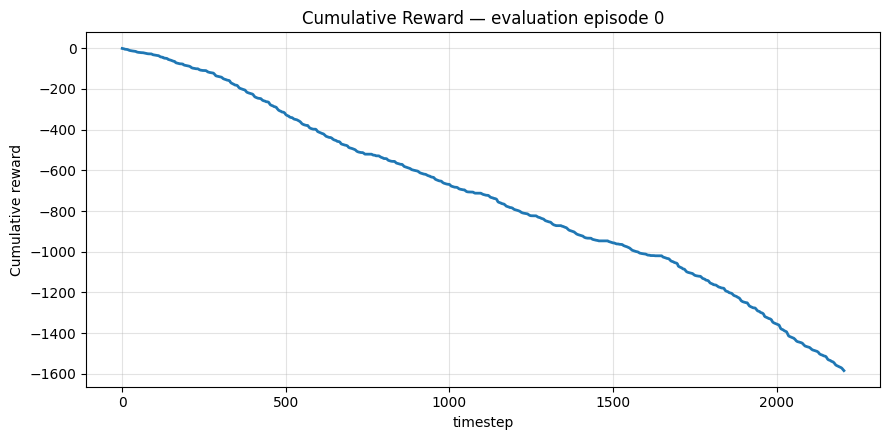

Episode length: 2207 steps | Return: -1584.091


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rbc_path = RBC_LOG_FILE

if not os.path.exists(rbc_path):
    raise FileNotFoundError(f"Logfile not found {os.path.abspath(rbc_path)}")

df = pd.read_csv(rbc_path)

reward_candidates = ["reward", "rewards", "step_reward", "step_rewards", "r"]
reward_col = next((c for c in reward_candidates if c in df.columns), None)
if reward_col is None:
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) == 1:
        reward_col = num_cols[0]
    else:
        raise ValueError(f"No unique reward column found: {list(df.columns)}")

t_candidates = ["timestep", "time_step", "t", "step", "index"]
t_col = next((c for c in t_candidates if c in df.columns), None)

rew = pd.to_numeric(df[reward_col], errors="coerce").dropna().to_numpy()
if rew.size == 0:
    raise ValueError(f"Reward column '{reward_col}' contains no valid numbers.")

cum = np.cumsum(rew)
x = df[t_col].iloc[:len(rew)].to_numpy() if t_col else np.arange(len(rew))

plt.figure(figsize=(9, 4.5))
plt.plot(x, cum, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel(t_col if t_col else "Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(rew)} steps | Return: {cum[-1]:.3f}")

#### DecisionTree

[target] column='_target_action_id' (source='_derived_action_id', mode='factorized')
n_features: 4 sample: ['net_load', 'price', 'soc', 'solar_generation']
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single 

Best balanced_accuracy: 1.0
Best params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Surrogate Tree Accuracy: 1.000
Confusion matrix (rows=true, cols=pred):
 [[552]]
                precision    recall  f1-score   support

discharge_full       1.00      1.00      1.00       552

      accuracy                           1.00       552
     macro avg       1.00      1.00      1.00       552
  weighted avg       1.00      1.00      1.00       552


Top feature importances:
Exported SVG -> /hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc_surrogate_tree.svg


/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/software/all/jupyter/ai/2025-05-23/lib/python3.11/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single 

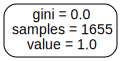

('/hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc_surrogate_tree.svg', None)

In [ ]:
# ===================== RBC Surrogate Decision Tree (state -> action) =====================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ===================== Configuration =====================
DEFAULT_TEST_SIZE    = 0.25
DEFAULT_RANDOM_STATE = 0
DEFAULT_N_SPLITS     = 5
DEFAULT_BINS         = 5        # Discretization for continuous commands (e.g., power setpoint)

# Optional: paths/environment (you can set these earlier in the notebook)
RBC_LOG_FILE = globals().get("RBC_LOG_FILE", "")  # e.g., "path/to/rbc_log.csv"
LOG_DIR      = globals().get("LOG_DIR", ".")      # Save SVG/PNG here

# Optional: custom labels/mappings (if actions are discrete)
ACTION_LABELS = globals().get("ACTION_LABELS", ["discharge_full","discharge_half","idle","charge_half","charge_full"])
INT_TO_FRAC   = globals().get("INT_TO_FRAC",   [-1.0,-0.5,0.0,0.5,1.0])

# Candidates for discrete action columns
ACTION_ID_CANDIDATES = [
    "action_id", "rbc_action_id", "only_device_action_id",
    "act_id", "decision_id", "cmd_id", "power_cmd_id",
    "action", "act", "decision"
]
# Candidates for continuous commands (if no IDs)
ACTION_CONT_CANDIDATES = [
    "command", "cmd", "power_cmd", "setpoint", "set_point",
    "power", "p_set", "p_cmd", "battery_power", "storage_power"
]

# Never use as features (leaks/meta)
EXPLICIT_DROP = {
    "global_step", "env_id", "episode", "step", "timestep",
    "reward", "done", "terminal", "truncate",
    "action_id", "rbc_action_id", "only_device_action_id",
    "action", "action_label", "action_frac",
    "act_id", "decision_id", "decision",
    "cmd_id", "power_cmd_id", "policy_action", "chosen_action"
}

# Forbidden substrings (stronger than a simple prefix check)
BAN_SUBSTR = (
    "action", "act", "cmd", "decision", "policy",
    "reward", "done", "terminal", "adv", "return", "value",
    "target", "future", "next_", "label", "y_", "gt_", "truth"
)

# ===================== Loader =====================
def read_any_log(path: str) -> pd.DataFrame:
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f"Log file not found: {os.path.abspath(path) if path else path}")
    ext = os.path.splitext(path)[1].lower()
    if ext in (".csv", ".tsv"):
        try:
            return pd.read_csv(path)
        except Exception:
            return pd.read_csv(path, sep=None, engine="python")
    if ext in (".jsonl", ".ndjson"):
        rows = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line: continue
                try:
                    rows.append(json.loads(line))
                except json.JSONDecodeError:
                    rows.append(json.loads(line.rstrip(",")))
        return pd.DataFrame(rows)
    if ext == ".json":
        data = json.load(open(path, "r", encoding="utf-8"))
        if isinstance(data, list):
            return pd.DataFrame(data)
        if isinstance(data, dict) and "data" in data and isinstance(data["data"], list):
            return pd.DataFrame(data["data"])
        return pd.json_normalize(data)
    # Fallback CSV
    return pd.read_csv(path)

# ===================== Target/feature detection =====================
def _pick_action_column(df: pd.DataFrame):
    # 1) numeric ID candidates
    for c in ACTION_ID_CANDIDATES:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c, "id"
    # 2) strings/categories -> factorize
    for c in ACTION_ID_CANDIDATES:
        if c in df.columns:
            ids, _ = pd.factorize(df[c])
            df["_derived_action_id"] = ids.astype(int)
            return "_derived_action_id", "factorized"
    # 3) continuous commands
    for c in ACTION_CONT_CANDIDATES:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c, "continuous"
    # 4) last resort: column name contains "action"
    for c in df.columns:
        if "action" in c.lower() and pd.api.types.is_numeric_dtype(df[c]):
            return c, "id"
    raise KeyError("Keine geeignete Aktionsspalte gefunden.")

def _discretize_if_needed(df: pd.DataFrame, col: str, mode: str, bins: int = DEFAULT_BINS):
    if mode in ("id", "factorized"):
        y = df[col].astype(int)
        k = int(y.max()) + 1 if y.min() == 0 else len(np.unique(y))
        # Labels from globals (optional)
        try:
            if ACTION_LABELS and len(ACTION_LABELS) >= k:
                class_names = list(ACTION_LABELS[:k])
            elif INT_TO_FRAC:
                mapping = {-1.0:"discharge_full",-0.5:"discharge_half",0.0:"idle",0.5:"charge_half",1.0:"charge_full"}
                class_names = [mapping.get(float(INT_TO_FRAC[i]), str(INT_TO_FRAC[i])) for i in range(k)]
            else:
                class_names = [str(i) for i in sorted(np.unique(y))]
        except Exception:
            class_names = [str(i) for i in sorted(np.unique(y))]
        df["_target_action_id"] = y.to_numpy()
        return "_target_action_id", class_names

    # continuous -> discretize
    x = df[col].astype(float).to_numpy()
    finite = np.isfinite(x)
    if finite.sum() == 0:
        raise ValueError("Kontinuierliche Aktionsspalte enthält keine finiten Werte.")
    x = np.where(finite, x, 0.0)

    # few distinct values -> exact factorization
    if len(np.unique(x)) < bins:
        uniq = np.sort(np.unique(x))
        mapping = {v: i for i, v in enumerate(uniq)}
        y = np.array([mapping.get(v, 0) for v in x])
        class_names = [f"{v:.4g}" for v in uniq]
        df["_target_action_id"] = y
        return "_target_action_id", class_names

    # odd number of bins: symmetric around 0 (discharge/idle/charge)
    if bins % 2 == 1:
        q = np.quantile(np.abs(x), np.linspace(0, 1, (bins + 1)//2 + 1))
        q = np.unique(q)
        neg_edges = -q[::-1]; pos_edges = q
        edges = np.unique(np.concatenate([neg_edges, pos_edges]))
        edges[0]  = min(edges[0],  x.min()) - 1e-9
        edges[-1] = max(edges[-1], x.max()) + 1e-9
        y = np.digitize(x, edges) - 1
        uniq = np.unique(y)
        remap = {v:i for i,v in enumerate(uniq)}
        y = np.array([remap[v] for v in y])
        k = len(uniq); mid = k//2
        class_names = [("discharge_"+str(mid-i)) if i<mid else ("idle" if i==mid else "charge_"+str(i-mid)) for i in range(k)]
        df["_target_action_id"] = y
        return "_target_action_id", class_names

    # even number of bins: quantile binning
    q = np.quantile(x, np.linspace(0, 1, bins + 1))
    q = np.unique(q)
    if len(q) - 1 < bins:
        q = np.linspace(x.min(), x.max(), bins + 1)
    y = np.digitize(x, q[1:-1])
    class_names = [f"[{q[i]:.3g},{q[i+1]:.3g})" for i in range(len(q) - 1)]
    df["_target_action_id"] = y
    return "_target_action_id", class_names

def _is_leaky(col: str, target_col: str) -> bool:
    if col == target_col: return True
    if col in EXPLICIT_DROP: return True
    low = col.lower()
    return any(s in low for s in BAN_SUBSTR)

def _select_features(df: pd.DataFrame, target_col: str):
    num_bool = df.select_dtypes(include=[np.number, bool]).columns
    feat_cols = [c for c in num_bool if not _is_leaky(c, target_col)]
    if not feat_cols:
        # try object->numeric
        for c in df.columns:
            if _is_leaky(c, target_col): continue
            if pd.api.types.is_object_dtype(df[c]):
                try:
                    df[c] = pd.to_numeric(df[c])
                    feat_cols.append(c)
                except Exception:
                    pass
    # remove suspiciously perfectly correlated columns
    if feat_cols:
        y = df[target_col].astype(float)
        corr = pd.Series({c: df[c].corr(y) for c in feat_cols if df[c].std() > 0})
        too_good = corr[corr.abs() > 0.99].index.tolist()
        if too_good:
            print("Dropping suspicious (≈target) features:", too_good)
            feat_cols = [c for c in feat_cols if c not in too_good]

    assert feat_cols, "Keine brauchbaren Features – prüfe deine Spalten/Filter!"
    feat_cols = sorted(set(feat_cols))
    print("n_features:", len(feat_cols), "sample:", feat_cols[:10])
    return feat_cols

# ===================== Training & explainability =====================
def train_rbc_surrogate_tree(df: pd.DataFrame, bins: int = DEFAULT_BINS, random_state: int = DEFAULT_RANDOM_STATE):
    action_col, mode = _pick_action_column(df)
    target_col, class_names = _discretize_if_needed(df, action_col, mode, bins=bins)
    print(f"[target] column='{target_col}' (source='{action_col}', mode='{mode}')")

    feat_cols = _select_features(df, target_col)
    X = df[feat_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
    y = df[target_col].astype(int).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=DEFAULT_TEST_SIZE, random_state=random_state, stratify=y
    )

    # Compact grid, depth strictly 5
    param_grid = {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [5],
        "min_samples_leaf": [1, 5, 10, 25, 50],
        "min_samples_split": [2, 5, 10, 20],
        "class_weight": [None, "balanced"],
        "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
        "splitter": ["best"]
    }
    cv = StratifiedKFold(n_splits=DEFAULT_N_SPLITS, shuffle=True, random_state=random_state)
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=random_state),
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best balanced_accuracy:", grid.best_score_)
    print("Best params:", grid.best_params_)

    clf = grid.best_estimator_

    # Quality
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Surrogate Tree Accuracy: {acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=[str(x) for x in class_names]))

    # Feature importances
    print("\nTop feature importances:")
    imp = clf.feature_importances_
    assert len(imp) == len(feat_cols), "Mismatch zwischen Importances und Feature-Namen."
    imp_idx = np.argsort(imp)[::-1]
    for i in imp_idx[:10]:
        if imp[i] <= 0: break
        print(f"- {feat_cols[i]}: {imp[i]:.4f}")

    # Local explanation
    def explain_sample(idx_in_df: int):
        x = df.iloc[idx_in_df][feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).to_numpy().reshape(1, -1)
        true_a = int(df.iloc[idx_in_df][target_col])
        pred_a = int(clf.predict(x)[0])
        proba  = clf.predict_proba(x)[0]
        tree = clf.tree_
        node = 0
        path = []
        while tree.feature[node] != -2:  # -2 => leaf
            f_idx = tree.feature[node]
            thr = tree.threshold[node]
            val = float(x[0, f_idx])
            go_left = val <= thr
            path.append((feat_cols[f_idx], val, thr, "left" if go_left else "right"))
            node = tree.children_left[node] if go_left else tree.children_right[node]
        def _label(a):
            try: return class_names[a]
            except Exception: return str(a)
        proba_dict = {str(class_names[i]): round(float(p), 3) for i, p in enumerate(proba)}
        print(f"True action: {true_a} ({_label(true_a)}), Pred: {pred_a} ({_label(pred_a)})")
        print(f"Proba: {proba_dict}")
        print("Decision path:")
        for name, val, thr, side in path:
            print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
        return pred_a

    return {
        "clf": clf,
        "feat_cols": feat_cols,
        "class_names": class_names,
        "target_col": target_col,
        "df": df,
        "explain_sample": explain_sample,
    }

# ===================== Export =====================
def export_tree_svg_png(clf, feature_names, class_names, out_dir=LOG_DIR):
    from IPython.display import SVG, display
    os.makedirs(out_dir, exist_ok=True)
    out_svg, out_png = None, None
    try:
        dot = export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=[str(c) for c in class_names],
            filled=True,
            rounded=True,
            special_characters=True,
        )
        src = graphviz.Source(dot)
        svg_bytes = src.pipe(format='svg')
        out_svg = os.path.join(out_dir, "rbc_surrogate_tree.svg")
        with open(out_svg, "wb") as f:
            f.write(svg_bytes)
        print(f"Exported SVG -> {out_svg}")
        display(SVG(src.pipe(format='svg'))) 
    except Exception as e:
        print("Graphviz unavailable; fallback to matplotlib. Error:", e)
        plt.figure(figsize=(32, 16), dpi=250)
        plot_tree(
            clf,
            feature_names=feature_names,
            class_names=[str(c) for c in class_names],
            filled=True,
            rounded=True,
            max_depth=5,
            fontsize=12
        )
        plt.tight_layout()
        out_png = os.path.join(out_dir, "rbc_surrogate_tree.png")
        plt.savefig(out_png, bbox_inches="tight", dpi=200)
        plt.close()
        print(f"Exported PNG -> {out_png}")
    return out_svg, out_png

df_rbc = read_any_log(RBC_LOG_FILE)
artifacts = train_rbc_surrogate_tree(df_rbc, bins=5)
export_tree_svg_png(artifacts["clf"], artifacts["feat_cols"], artifacts["class_names"])